In [59]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
sns.set_style('whitegrid')

# Указание пути до всех csv файлов и их загрузка

In [60]:
comp_dir = Path('store-sales-time-series-forecasting')

In [61]:
df_holidays = pd.read_csv(comp_dir / 'holidays_events.csv', header = 0)
df_oil = pd.read_csv(comp_dir /'oil.csv', header = 0)
df_stores = pd.read_csv(comp_dir / 'stores.csv', header = 0)
df_trans = pd.read_csv(comp_dir / 'transactions.csv', header = 0)

df_train = pd.read_csv(comp_dir / 'train.csv', header = 0)
df_test = pd.read_csv(comp_dir / 'test.csv', header = 0)

In [62]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
df_train['date'] = pd.to_datetime(df_train['date'], format = "%Y-%m-%d")
df_test['date'] = pd.to_datetime(df_test['date'], format = "%Y-%m-%d")

# Просмотр содержимого загруженных данных

In [63]:
df_holidays.head(10)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [64]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [65]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [66]:
df_trans.head()


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [67]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,2483653,2016-10-28,46,CLEANING,2576.000,61
1,2761877,2017-04-03,52,DAIRY,0.000,0
2,1217988,2014-11-16,33,MEATS,357.354,2
3,1231938,2014-11-24,25,HOME AND KITCHEN I,5.000,0
4,528175,2013-10-24,29,EGGS,0.000,0


In [68]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


# Сгруппируем даты по неделям со средним значением

In [69]:
def grouped(df, key, freq, col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [70]:
df_grouped_trans_w = grouped(df_trans, 'date', 'W', 'transactions')
df_grouped_trans_w

,date,mean
0,2013-01-06,1883.203463
1,2013-01-13,1641.090062
2,2013-01-20,1639.024845
3,2013-01-27,1609.816770
4,2013-02-03,1685.263975
...,...,...
237,2017-07-23,1623.208995
238,2017-07-30,1619.653439
239,2017-08-06,1713.743386
240,2017-08-13,1599.156085


# Добавим колонку 'time' в DF

In [71]:
def add_time(df, key, freq, col):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [72]:
df_grouped_train_w = add_time(df_train, 'date', 'W', 'sales')
df_grouped_train_m = add_time(df_train, 'date', 'ME', 'sales')

df_grouped_train_w.head()

,date,time,mean
0,2013-01-06,0,207.302324
1,2013-01-13,1,193.443638
2,2013-01-20,2,191.173330
3,2013-01-27,3,182.880213
4,2013-02-03,4,197.026754


In [73]:
def plot_stats(df, column, ax, angle):
    """ PLOT STATS OF DIFFERENT COLUMNS """
    count_classes = df[column].value_counts()
    ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, hue=count_classes, palette='Paired')
    ax.set_title(column.upper(), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

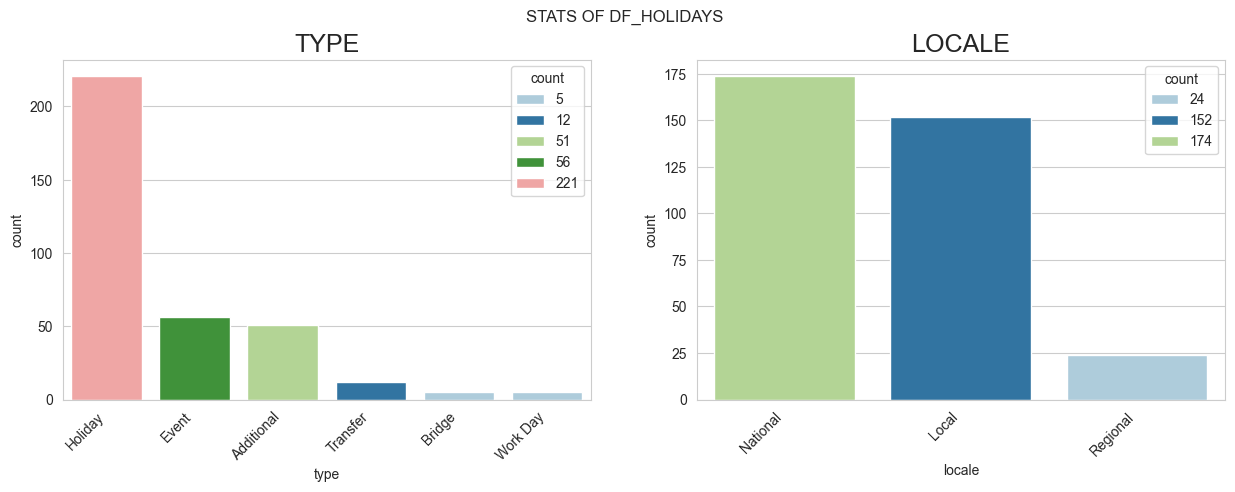

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.autofmt_xdate()
fig.suptitle("Stats of df_holidays".upper())
plot_stats(df_holidays, "type", axes[0], 45)
plot_stats(df_holidays, "locale", axes[1], 45)
plt.show()

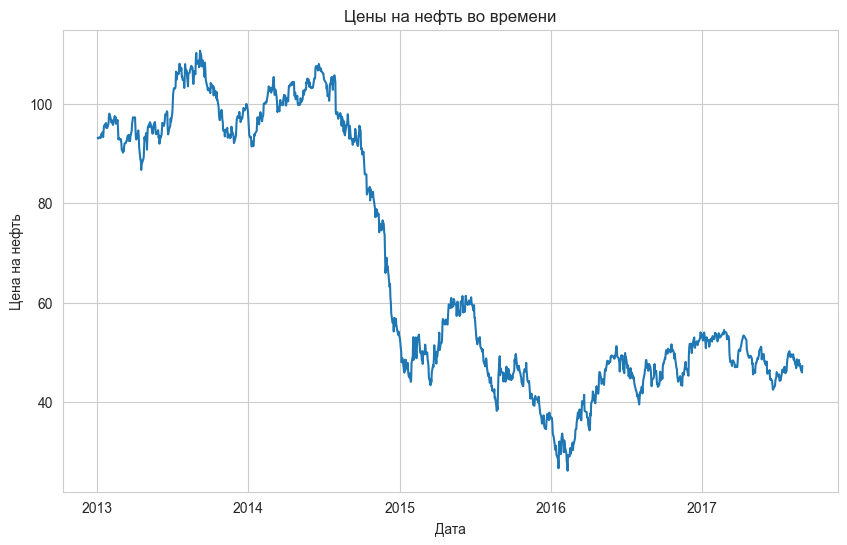

In [75]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_oil, x='date', y='dcoilwtico')
plt.title('Цены на нефть во времени')
plt.xlabel('Дата')
plt.ylabel('Цена на нефть')
plt.show()



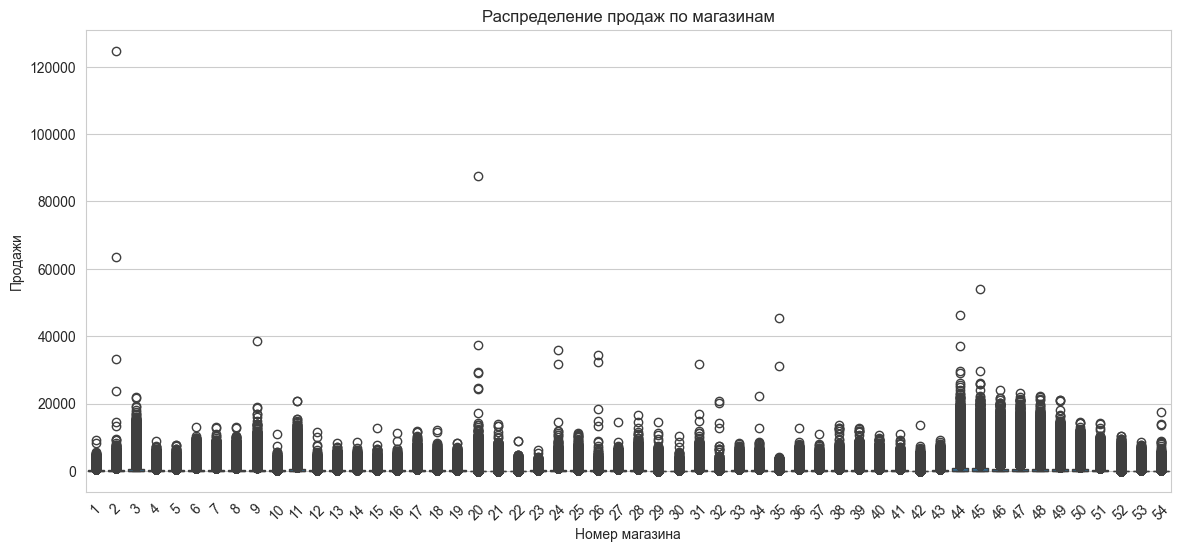

In [76]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_train, x='store_nbr', y='sales')
plt.title('Распределение продаж по магазинам')
plt.xlabel('Номер магазина')
plt.ylabel('Продажи')
plt.xticks(rotation=45)
plt.show()


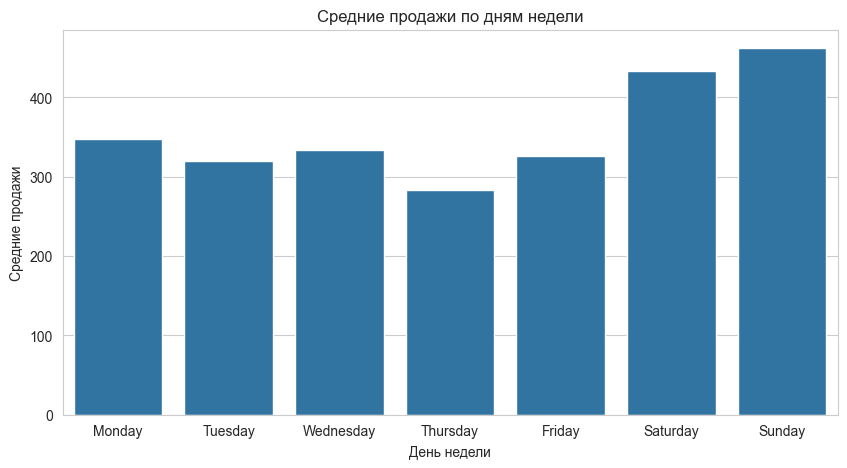

In [77]:
df_train['day_of_week'] = df_train['date'].dt.day_name()  # Извлечение названия дня недели из даты
avg_sales_day = df_train.groupby('day_of_week')['sales'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_sales_day.index, y=avg_sales_day.values)
plt.title('Средние продажи по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средние продажи')
plt.show()


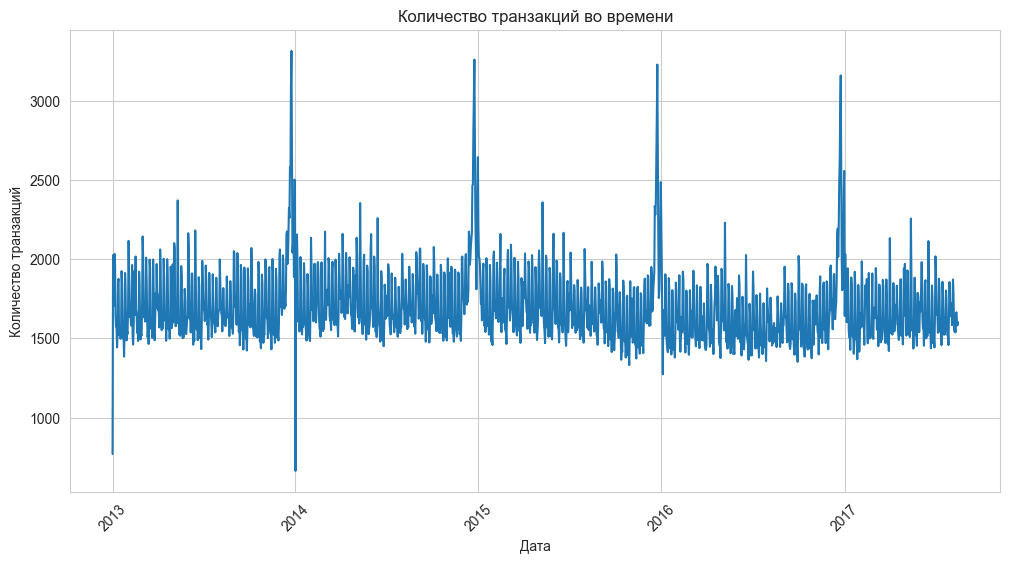

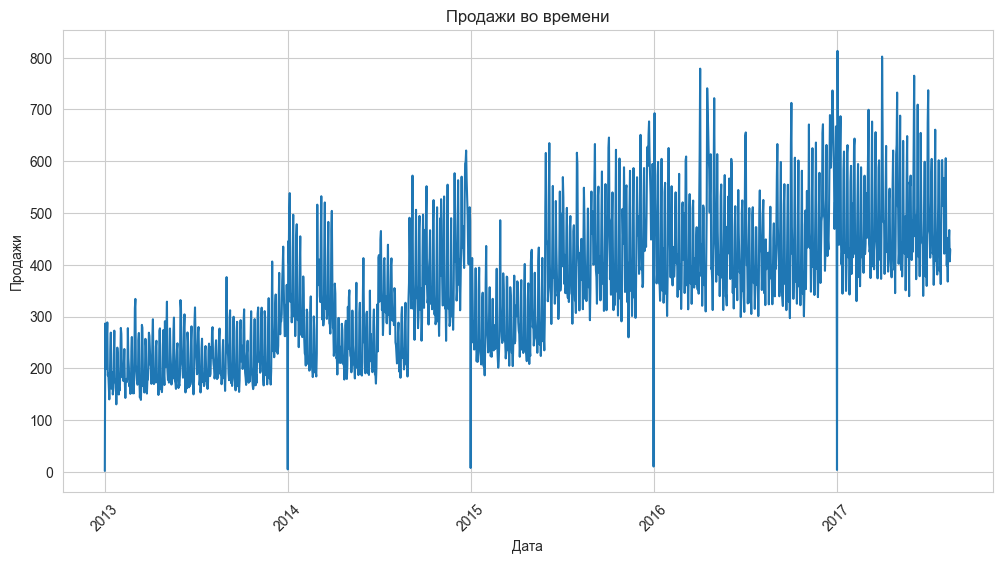

In [83]:
# Временные ряды для транзакций
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_trans, x='date', y='transactions', errorbar=None)
plt.title('Количество транзакций во времени')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=45)
plt.show()

# Временные ряды для продаж
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_train, x='date', y='sales', errorbar=None)
plt.title('Продажи во времени')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.xticks(rotation=45)
plt.show()
